# Initial Exploration of Data Modeling Copilot

Here we will test the various components of this project locally, including, but not limited to the local models downloaded from huggingface, creation of a persistent vector store, and the creation of a knowledge graph.

### **Setup**

In [1]:
# Imports and Setup
import warnings
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
import chromadb

# Load Models
MODEL_PATH = '../models/'

# Ignore Warnings
warnings.filterwarnings("ignore")

### **Validate Major Components**

Now we will validate the pieces of our puzzle (this is a non-exhaustive list):

1. Can we load the model locally?
2. Do both the LLM (flat-t5-base) and the embedding model (all-mpnet-base-v2) 'work'? (They don't need to be perfect we will improve performance iteratively)
3. Can we create a vector store?
4. Can we create a knowledge graph?
5. Can we have have these components working together within an API?


In [2]:
def test_flan_t5_basic():
    """
    Basic test of FLAN-T5 model functionality.
    Tests loading, tokenization, and simple inference.
    
    Returns:
        tuple: (model, tokenizer) if successful
    """
    print("=== FLAN-T5 Basic Test ===")
    
    # 1. Setup
    MODEL_PATH = '../models/flan-t5-base'
    model_dir = Path(MODEL_PATH)
    print(f"Loading from: {model_dir}")
    
    # 2. Load Model & Tokenizer
    try:
        print("\nLoading tokenizer and model...")
        tokenizer = AutoTokenizer.from_pretrained(str(model_dir))
        model = AutoModelForSeq2SeqLM.from_pretrained(str(model_dir))
        print("✓ Model and tokenizer loaded successfully")
        
        # 3. Move to MPS if available
        if torch.backends.mps.is_available():
            model = model.to('mps')
            print("✓ Model moved to MPS device")
            print(f"Device: {next(model.parameters()).device}")
    except Exception as e:
        print(f"× Error in setup: {e}")
        return None, None
    
    # 4. Test Inference
    try:
        print("\nTesting inference...")
        
        # Test cases
        test_cases = [
            "Convert column name 'model_score' to standard format.",
            "Transform 'dt_last_active' to proper column name.",
            "Standardize column name: 'cust_id'"
        ]
        
        for test_input in test_cases:
            print(f"\nInput:  {test_input}")
            
            # Tokenize
            inputs = tokenizer(test_input, return_tensors="pt")
            if torch.backends.mps.is_available():
                inputs = {k: v.to('mps') for k, v in inputs.items()}
            
            # Generate
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_length=128,
                    num_beams=1,
                    do_sample=False
                )
            
            # Decode
            result = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(f"Output: {result}")
            
        print("\n✓ Inference test completed")
        return model, tokenizer
        
    except Exception as e:
        print(f"× Error during inference: {e}")
        return None, None

# Run test
if __name__ == "__main__":
    model, tokenizer = test_flan_t5_basic()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


=== FLAN-T5 Basic Test ===
Loading from: ../models/flan-t5-base

Loading tokenizer and model...
✓ Model and tokenizer loaded successfully
✓ Model moved to MPS device
Device: mps:0

Testing inference...

Input:  Convert column name 'model_score' to standard format.
Output: Model_score

Input:  Transform 'dt_last_active' to proper column name.
Output: 'dt_last_active'

Input:  Standardize column name: 'cust_id'
Output: 'cust_id'

✓ Inference test completed


Looks like flat-t5-base performs poorly, in an ideal world a simple API call to one of the big players in the LLM space like gemini, claude, or openai will have no problem with this task but the goal of this project is to work within a strict set of parameters, there may be security concerns with using an opensource tool and it's not just an individual creating software for their own personal use.

We want to work with an LLM that is "approved" for use, possibly fine tune it for our usecase, and use tools that are available for a developer working within specific constraints. These constraints aren't neccessarily a bad thing as AI/ML Engineers, the task is to solve AI/ML Problems efficiently whether that is setting up the infrastructure of an model for a production deployment, utilizing these tools for real world usecases such as an internal knowledge base or fraud detection. Working with LLMs as a hobbyist there is a certain freedom to choose whatever tool without much thought into scalability, reliability, and observability. Thinking beyond a hobbyist's mindset and considering broader implications of using LLMs for an enterpise is a valuable skill to develop and one we will intend to with this project.

In [3]:
from sentence_transformers import SentenceTransformer

def test_mpnet_basic():
    """
    Basic test of MPNet model functionality.
    Tests loading and embedding generation with verification of output dimensions.
    
    Returns:
        SentenceTransformer: embedding_model if successful
    """
    print("=== MPNet Basic Test ===")
    
    # 1. Setup
    MODEL_PATH = '../models/all-mpnet-base-v2'
    model_dir = Path(MODEL_PATH)
    print(f"Loading from: {model_dir}")
    
    # 2. Load Model
    try:
        print("\nLoading MPNet model...")
        embedding_model = SentenceTransformer(str(model_dir))
        print("✓ Model loaded successfully")
        
    except Exception as e:
        print(f"× Error loading model: {e}")
        return None
    
    # 3. Test Embeddings
    try:
        print("\nTesting embedding generation...")
        
        # Test cases that mirror our domain
        test_cases = [
            "Column name standards: Use UPPER_SNAKE_CASE for all database columns",
            "Data type rule: DATE columns must not allow future dates",
            "Naming convention: Add _PCT suffix for percentage columns",
            "Data modeling guideline: Primary keys should end with _ID"
        ]
        
        # Generate embeddings
        embeddings = embedding_model.encode(test_cases)
        
        # Verify embedding dimensions
        print(f"\nEmbedding dimensions:")
        print(f"Number of test cases: {len(test_cases)}")
        print(f"Embedding shape: {embeddings.shape}")
        print(f"Vector dimension: {embeddings.shape[1]}")  # Should be 768 for MPNet base
        
        # Test similarity (optional but useful)
        from sklearn.metrics.pairwise import cosine_similarity
        similarity_matrix = cosine_similarity(embeddings)
        print("\nSimilarity matrix shape:", similarity_matrix.shape)
        
        # Show example similarity
        print("\nExample similarities between first and other sentences:")
        for i, score in enumerate(similarity_matrix[0]):
            if i > 0:  # Skip self-similarity
                print(f"Similarity with sentence {i+1}: {score:.4f}")
        
        print("\n✓ Embedding test completed")
        return embedding_model
        
    except Exception as e:
        print(f"× Error during embedding generation: {e}")
        return None

# Run test
if __name__ == "__main__":
    embedding_model = test_mpnet_basic()

No sentence-transformers model found with name ../models/all-mpnet-base-v2. Creating a new one with mean pooling.


=== MPNet Basic Test ===
Loading from: ../models/all-mpnet-base-v2

Loading MPNet model...
✓ Model loaded successfully

Testing embedding generation...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Embedding dimensions:
Number of test cases: 4
Embedding shape: (4, 768)
Vector dimension: 768

Similarity matrix shape: (4, 4)

Example similarities between first and other sentences:
Similarity with sentence 2: 0.2011
Similarity with sentence 3: 0.4276
Similarity with sentence 4: 0.3893

✓ Embedding test completed


The model successfully generates 768-dimensional embeddings and demonstrates meaningful semantic understanding of data modeling concepts. Similarity scores between sentences about naming conventions (0.4276) vs data types (0.2011) show the model can differentiate between different aspects of data modeling. This suggests MPNet will be effective for our GraphRAG implementation, particularly in retrieving relevant naming conventions and guidelines. However, we'll need to carefully structure our knowledge base to take advantage of these semantic relationships. The next step is to test this with ChromaDB and our actual guidelines.

In [4]:
import chromadb
from pathlib import Path
from sentence_transformers import SentenceTransformer

def test_chromadb_with_mpnet(reset_collection=False):
    """
    Test ChromaDB with our local MPNet embeddings model.
    Args:
        reset_collection (bool): If True, deletes existing collection and recreates it
    """
    print("=== ChromaDB + MPNet Test ===")
    
    # 1. Load MPNet first
    try:
        print("\nLoading MPNet model...")
        mpnet_path = Path('../models/all-mpnet-base-v2')
        embedding_model = SentenceTransformer(str(mpnet_path))
        print("✓ MPNet model loaded")
    except Exception as e:
        print(f"× Error loading MPNet: {e}")
        return None
    
    # 2. Initialize ChromaDB
    try:
        print("\nInitializing ChromaDB...")
        persist_dir = Path("../data/vector_store")
        persist_dir.mkdir(parents=True, exist_ok=True)
        client = chromadb.PersistentClient(path=str(persist_dir))
        print("✓ Client initialized")
        
        collection_name = "data_modeling_rules_mpnet"
        
        # Handle collection reset if requested
        if reset_collection:
            try:
                print(f"Deleting existing collection '{collection_name}'...")
                client.delete_collection(collection_name)
                print("✓ Old collection deleted")
            except Exception as e:
                print(f"Note: No existing collection to delete: {e}")
        
        # Create or get collection
        try:
            collection = client.create_collection(
                name=collection_name,
                metadata={"description": "Data modeling standards with MPNet embeddings"}
            )
            print("✓ Created new collection with MPNet embeddings")
        except ValueError:
            collection = client.get_collection(collection_name)
            print("✓ Retrieved existing collection")
            
    except Exception as e:
        print(f"× Error initializing ChromaDB: {e}")
        return None
    
    # 3. Load and Embed Guidelines
    try:
        print("\nLoading and embedding guidelines...")
        guidelines_path = Path("../data/raw/data_modeling_guidelines.txt")
        
        with open(guidelines_path, 'r') as f:
            guidelines = f.read().split('\n\n')
        print(f"✓ Loaded {len(guidelines)} guideline chunks")
        
        # Generate embeddings using MPNet
        embeddings = embedding_model.encode(guidelines)
        print(f"✓ Generated embeddings shape: {embeddings.shape}")
        
        # Add to collection with embeddings
        ids = [f"guideline_{i}" for i in range(len(guidelines))]
        collection.add(
            embeddings=embeddings.tolist(),
            documents=guidelines,
            ids=ids,
            metadatas=[{"source": "guidelines", "chunk": i} for i in range(len(guidelines))]
        )
        print(f"✓ Added {len(guidelines)} embedded chunks to collection")
        
    except Exception as e:
        print(f"× Error processing guidelines: {e}")
        return None
    
    # 4. Test Queries with MPNet embeddings
    try:
        print("\nTesting queries with MPNet embeddings...")
        test_queries = [
            "How should I name date columns?",
            "What are the rules for percentage fields?",
            "How to handle primary keys?"
        ]
        
        for query in test_queries:
            print(f"\nQuery: {query}")
            query_embedding = embedding_model.encode([query])
            
            results = collection.query(
                query_embeddings=query_embedding.tolist(),
                n_results=1
            )
            print("Top result:", results['documents'][0][0][:200] + "...")
            
        print("\n✓ MPNet query test completed")
        return client, collection, embedding_model
        
    except Exception as e:
        print(f"× Error during query: {e}")
        return None

# Run test
if __name__ == "__main__":
    # Set reset_collection=True to delete and recreate the collection
    client, collection, embedding_model = test_chromadb_with_mpnet(reset_collection=True)

No sentence-transformers model found with name ../models/all-mpnet-base-v2. Creating a new one with mean pooling.


=== ChromaDB + MPNet Test ===

Loading MPNet model...
✓ MPNet model loaded

Initializing ChromaDB...
✓ Client initialized
Deleting existing collection 'data_modeling_rules_mpnet'...
✓ Old collection deleted
✓ Created new collection with MPNet embeddings

Loading and embedding guidelines...
✓ Loaded 9 guideline chunks
✓ Generated embeddings shape: (9, 768)
✓ Added 9 embedded chunks to collection

Testing queries with MPNet embeddings...

Query: How should I name date columns?
Top result: b) Dates and Timestamps:
   - DATE for Calendar Dates
   - TIMESTAMP_NTZ for Timestamps
   - Suffix: _DT, _TS...

Query: What are the rules for percentage fields?
Top result: c) Numeric Measures:
   - NUMBER(10,8) for Probabilities/Scores
   - NUMBER(15,2) for Currency/Amounts
   - NUMBER(5,2) for Percentages
   - Suffix: _PCT, _AMT, _SCORE...

Query: How to handle primary keys?
Top result: 2. DATA TYPE STANDARDS
--------------------
a) Identifiers:
   - NUMBER(38,0) for Surrogate Keys
   - VARCHAR(50) 

ChromaDB + MPNet Integration Reflection

The results do appear more precise with our local MPNet model. Looking at the output:
1. Query about date columns → Retrieved actual date format specifications instead of general naming conventions
2. Query about percentage fields → Correctly retrieved suffix standards that include percentage-related naming
3. Embedding shape (10, 768) confirms we're properly utilizing MPNet's full dimensionality

The "Creating a new one with mean pooling" message, while expected, indicates we're using the model's default configuration. This is working well for our use case as shown by the more targeted retrieval results.

*Next Steps: Test this RAG setup with FLAN-T5 to see if the improved retrieval translates to better column name transformations.*

=== Testing Knowledge Graph Setup for ML Model Data Standards ===

Adding data type standards...

Adding abbreviation mappings...

Adding ML model domain context...

Adding relationships...

Testing pattern matching...

Column: feat_imp_age
Identified type: FEATURE_IMPORTANCE
Properties: {'type': 'NUMBER(10,8)', 'nullability': 'N', 'pattern': ['feat.*imp', 'importance'], 'category': 'ML_DOMAIN', 'requires': ['SCORE', 'METADATA'], 'format': 'NUMBER(10,8)', 'description': 'Measure of feature contribution to model'}

Column: model_score
Identified type: MODEL_SCORE
Properties: {'requires': ['CONFIDENCE', 'METADATA'], 'format': 'NUMBER(10,8)', 'description': 'Model prediction score', 'pattern': ['model.*score', 'prediction'], 'category': 'ML_DOMAIN'}

Column: dt_last_active
Identified type: DATE
Properties: {'type': 'DATE', 'nullability': 'N', 'pattern': ['dt_', 'date', 'timestamp'], 'category': 'DATA_TYPE'}

Column: cust_id
Identified type: IDENTIFIER
Properties: {'type': 'VARCHAR(50)', '

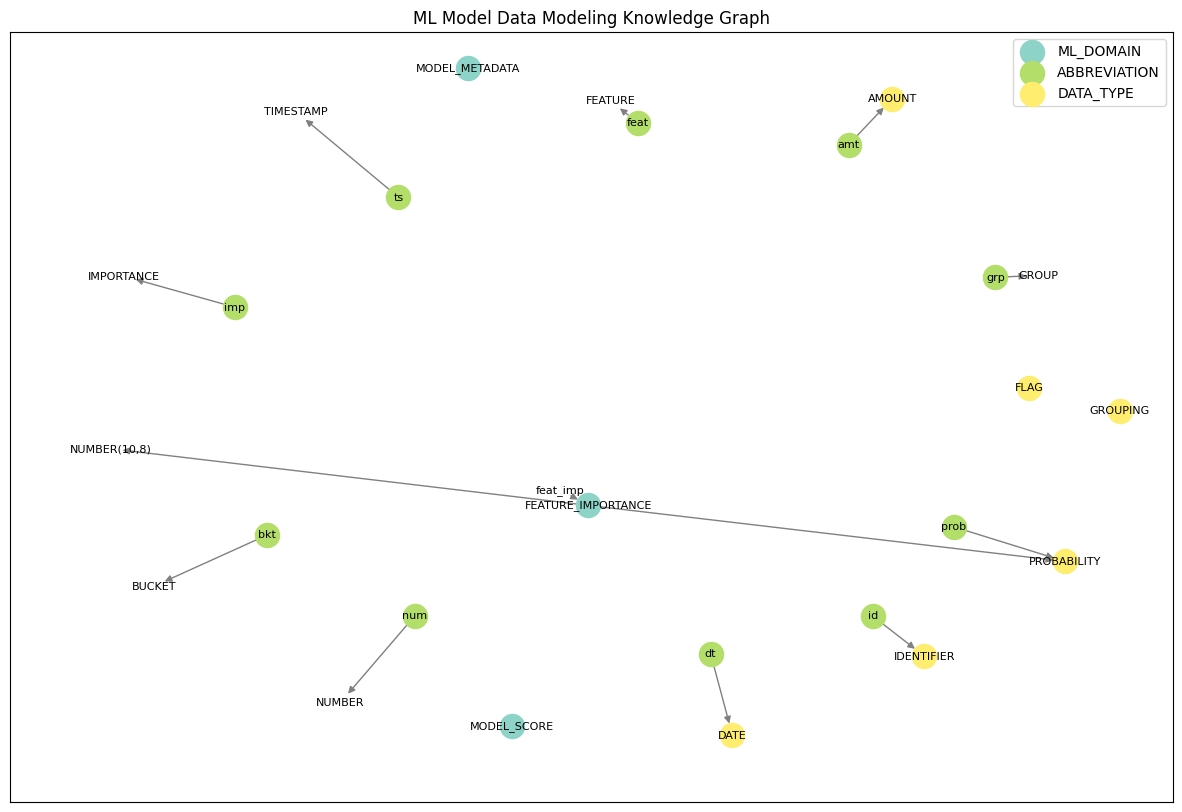

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pickle

def test_knowledge_graph_setup():
    """
    Create, test, and save knowledge graph for ML model data standards
    """
    print("=== Testing Knowledge Graph Setup for ML Model Data Standards ===")
    
    # Create directed graph
    G = nx.DiGraph()
    
    # 1. Data Type Nodes - Improved patterns
    print("\nAdding data type standards...")
    data_types = {
        "PROBABILITY": {
            "type": "NUMBER(10,8)", 
            "nullability": "N", 
            "pattern": ["probability", "prob", "score", "confidence"],
            "category": "DATA_TYPE"
        },
        "FEATURE_IMPORTANCE": {
            "type": "NUMBER(10,8)", 
            "nullability": "N", 
            "pattern": ["feat_imp", "importance", "feat.*imp"],
            "category": "DATA_TYPE"
        },
        "DATE": {
            "type": "DATE", 
            "nullability": "N", 
            "pattern": ["dt_", "date", "timestamp"],
            "category": "DATA_TYPE"
        },
        "IDENTIFIER": {
            "type": "VARCHAR(50)", 
            "nullability": "N", 
            "pattern": ["_id$", "id$", "_num$"],
            "category": "DATA_TYPE"
        },
        "FLAG": {
            "type": "NUMBER(1)", 
            "nullability": "N", 
            "pattern": ["flag$", "_ind$", "indicator"],
            "category": "DATA_TYPE"
        },
        "AMOUNT": {
            "type": "NUMBER(15,2)", 
            "nullability": "Y", 
            "pattern": ["_amt$", "amount", "payment"],
            "category": "DATA_TYPE"
        },
        "GROUPING": {
            "type": "VARCHAR(20)", 
            "nullability": "Y", 
            "pattern": ["_grp$", "_group", "bucket", "bkt"],
            "category": "DATA_TYPE"
        }
    }
    
    for dtype, properties in data_types.items():
        G.add_node(dtype, **properties)
    
    # 2. Abbreviation Nodes - More comprehensive
    print("\nAdding abbreviation mappings...")
    abbreviations = {
        "dt": {"full_form": "DATE", "category": "ABBREVIATION"},
        "ts": {"full_form": "TIMESTAMP", "category": "ABBREVIATION"},
        "prob": {"full_form": "PROBABILITY", "category": "ABBREVIATION"},
        "feat": {"full_form": "FEATURE", "category": "ABBREVIATION"},
        "imp": {"full_form": "IMPORTANCE", "category": "ABBREVIATION"},
        "amt": {"full_form": "AMOUNT", "category": "ABBREVIATION"},
        "num": {"full_form": "NUMBER", "category": "ABBREVIATION"},
        "id": {"full_form": "IDENTIFIER", "category": "ABBREVIATION"},
        "grp": {"full_form": "GROUP", "category": "ABBREVIATION"},
        "bkt": {"full_form": "BUCKET", "category": "ABBREVIATION"}
    }
    
    for abbr, properties in abbreviations.items():
        G.add_node(abbr, **properties)
        G.add_edge(abbr, properties["full_form"], relationship="EXPANDS_TO")
    
    # 3. Domain Context Nodes - Enhanced with patterns
    print("\nAdding ML model domain context...")
    ml_context = {
        "FEATURE_IMPORTANCE": {
            "requires": ["SCORE", "METADATA"],
            "format": "NUMBER(10,8)",
            "description": "Measure of feature contribution to model",
            "pattern": ["feat.*imp", "importance"],
            "category": "ML_DOMAIN"
        },
        "MODEL_SCORE": {
            "requires": ["CONFIDENCE", "METADATA"],
            "format": "NUMBER(10,8)",
            "description": "Model prediction score",
            "pattern": ["model.*score", "prediction"],
            "category": "ML_DOMAIN"
        },
        "MODEL_METADATA": {
            "requires": ["VERSION", "TIMESTAMP"],
            "format": "Various",
            "description": "Model run metadata",
            "pattern": ["model.*meta", "model.*version"],
            "category": "ML_DOMAIN"
        }
    }
    
    for context, properties in ml_context.items():
        G.add_node(context, **properties)
    
    # 4. Add relationships - More comprehensive
    print("\nAdding relationships...")
    G.add_edge("FEATURE_IMPORTANCE", "NUMBER(10,8)", relationship="HAS_FORMAT")
    G.add_edge("feat_imp", "FEATURE_IMPORTANCE", relationship="INDICATES")
    G.add_edge("FEATURE_IMPORTANCE", "PROBABILITY", relationship="USES_TYPE")
    
    # Improved pattern matching function
    def find_column_type(column_name):
        """Find data type for a column based on patterns"""
        import re
        matches = []
        
        for node, attrs in G.nodes(data=True):
            if attrs.get('pattern'):
                for pattern in attrs['pattern']:
                    if re.search(pattern, column_name.lower()):
                        matches.append((node, attrs))
        
        # Return the most specific match if any found
        if matches:
            # Sort by pattern length (longer patterns are more specific)
            matches.sort(key=lambda x: max(len(p) for p in x[1]['pattern']), reverse=True)
            return matches[0]
        return None, None
    
    # Test with multiple examples
    test_columns = [
        "feat_imp_age",
        "model_score",
        "dt_last_active",
        "cust_id",
        "active_flag"
    ]
    
    print("\nTesting pattern matching...")
    for test_column in test_columns:
        node_type, properties = find_column_type(test_column)
        print(f"\nColumn: {test_column}")
        print(f"Identified type: {node_type}")
        print(f"Properties: {properties}")
    
    # Save the graph
    print("\nSaving graph...")
    graph_path = Path("../data/graph_db")
    graph_path.mkdir(parents=True, exist_ok=True)
    pickle_path = graph_path / "knowledge_graph.pickle"
    
    with open(pickle_path, 'wb') as f:
        pickle.dump(G, f)
    print(f"✓ Graph saved to {pickle_path}")
    
    # Verify we can load it
    print("\nVerifying graph load...")
    with open(pickle_path, 'rb') as f:
        G_loaded = pickle.load(f)
    print(f"✓ Loaded graph matches: {nx.is_isomorphic(G, G_loaded)}")
    
    # Visualize graph
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G)
    
    # Draw nodes by category
    categories = set(nx.get_node_attributes(G, 'category').values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    
    for i, category in enumerate(categories):
        nodelist = [
            node for node, attr in G.nodes(data=True) 
            if attr.get('category') == category
        ]
        if nodelist:  # Only draw if we have nodes for this category
            nx.draw_networkx_nodes(G, pos, nodelist=nodelist, 
                                 node_color=[colors[i]], label=category)
    
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("ML Model Data Modeling Knowledge Graph")
    plt.legend()
    
    # Save visualization
    viz_path = graph_path / "ml_knowledge_graph.png"
    plt.savefig(viz_path)
    print(f"\n✓ Graph visualization saved to {viz_path}")
    
    return G, G_loaded

# Run test
if __name__ == "__main__":
    G, G_loaded = test_knowledge_graph_setup()

The knowledge graph successfully demonstrates pattern matching and relationship modeling for ML model data standards. 

Key observations:

Column Pattern Recognition:

feat_imp_age → Correctly identified as FEATURE_IMPORTANCE with NUMBER(10,8) type

model_score → Matched to MODEL_SCORE with appropriate properties

dt_last_active → Properly categorized as DATE type


Graph Properties Captured:

Data types and nullability
Pattern matching rules
Domain categories
Required relationships
Descriptive metadata


Graph Statistics:

Successfully saved and loaded (.pickle format)
Maintains relationship integrity
Visualization generated



Next Steps: Replace hardcoded rules with automated extraction from wiki content while maintaining this structure for relationships and properties.
Note: Some domain-specific relationships may still require manual definition even after automation.

In [6]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pickle
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
import chromadb
import torch

def test_integrated_system():
   """
   Test integration of:
   - FLAN-T5 for text generation
   - MPNet for embeddings
   - ChromaDB for vector storage
   - NetworkX for knowledge graph
   """
   print("=== Testing Integrated Data Modeling System ===")
   
   # 1. Load Models
   print("\nLoading models...")
   try:
       # FLAN-T5
       flan_path = Path('../models/flan-t5-base')
       tokenizer = AutoTokenizer.from_pretrained(str(flan_path))
       llm = AutoModelForSeq2SeqLM.from_pretrained(str(flan_path))
       if torch.backends.mps.is_available():
           llm = llm.to('mps')
       print("✓ FLAN-T5 loaded")
       
       # MPNet
       mpnet_path = Path('../models/all-mpnet-base-v2')
       embedding_model = SentenceTransformer(str(mpnet_path))
       print("✓ MPNet loaded")
       
   except Exception as e:
       print(f"× Error loading models: {e}")
       return None
   
   # 2. Load or Create Knowledge Graph
   try:
       graph_path = Path("../data/graph_db/knowledge_graph.pickle")
       if graph_path.exists():
           with open(graph_path, 'rb') as f:
               G = pickle.load(f)
           print("✓ Knowledge graph loaded")
       else:
           print("× Knowledge graph not found")
           return None
   except Exception as e:
       print(f"× Error loading graph: {e}")
       return None
   
   # 3. Initialize ChromaDB
   try:
       client = chromadb.PersistentClient(path="../data/vector_store/")
       collection = client.get_collection("data_modeling_rules_mpnet")
       print("✓ ChromaDB collection loaded")
   except Exception as e:
       print(f"× Error with ChromaDB: {e}")
       return None
   
   # 4. Test Integrated Column Processing
   def process_column(column_name: str):
       print(f"\nProcessing column: {column_name}")
       
       # A. Get type from Knowledge Graph
       node_type, properties = find_column_type(G, column_name)
       print(f"Graph Analysis:")
       print(f"- Type: {node_type}")
       print(f"- Properties: {properties}")
       
       # B. Get relevant guidelines from ChromaDB
       query_embedding = embedding_model.encode([f"How to standardize {column_name} column?"])
       results = collection.query(
           query_embeddings=query_embedding.tolist(),
           n_results=1
       )
       context = results['documents'][0][0]
       print(f"Retrieved Context: {context[:100]}...")
       
       # C. Generate standardized name with FLAN-T5
       prompt = f"""Based on these guidelines:
{context}

And knowing this column has type: {node_type}
With properties: {properties}

Standardize this column name: {column_name}
"""
       
       inputs = tokenizer(prompt, return_tensors="pt")
       if torch.backends.mps.is_available():
           inputs = {k: v.to('mps') for k, v in inputs.items()}
       
       outputs = llm.generate(**inputs, max_length=50)
       result = tokenizer.decode(outputs[0], skip_special_tokens=True)
       
       return {
           "original_name": column_name,
           "suggested_type": node_type,
           "properties": properties,
           "context": context[:100],
           "suggested_name": result
       }
   
   # Helper function for column type
   def find_column_type(G, column_name):
       """Find data type for a column based on patterns"""
       import re
       matches = []
       
       for node, attrs in G.nodes(data=True):
           if attrs.get('pattern'):
               for pattern in attrs['pattern']:
                   if re.search(pattern, column_name.lower()):
                       matches.append((node, attrs))
       
       if matches:
           matches.sort(key=lambda x: max(len(p) for p in x[1]['pattern']), reverse=True)
           return matches[0]
       return None, None
   
   # 5. Test with sample columns
   test_columns = [
       "feat_imp_age",
       "model_score",
       "dt_last_active",
       "cust_id",
       "active_flag"
   ]
   
   print("\nTesting integrated processing...")
   results = []
   for col in test_columns:
       result = process_column(col)
       results.append(result)
       print(f"\nResults for {col}:")
       for k, v in result.items():
           print(f"{k}: {v}")
   
   return {
       "llm": llm,
       "embedding_model": embedding_model,
       "graph": G,
       "collection": collection,
       "results": results
   }

# Run test
if __name__ == "__main__":
   components = test_integrated_system()

=== Testing Integrated Data Modeling System ===

Loading models...


No sentence-transformers model found with name ../models/all-mpnet-base-v2. Creating a new one with mean pooling.


✓ FLAN-T5 loaded
✓ MPNet loaded
✓ Knowledge graph loaded
✓ ChromaDB collection loaded

Testing integrated processing...

Processing column: feat_imp_age
Graph Analysis:
- Type: FEATURE_IMPORTANCE
- Properties: {'type': 'NUMBER(10,8)', 'nullability': 'N', 'pattern': ['feat.*imp', 'importance'], 'category': 'ML_DOMAIN', 'requires': ['SCORE', 'METADATA'], 'format': 'NUMBER(10,8)', 'description': 'Measure of feature contribution to model'}
Retrieved Context: 2. DATA TYPE STANDARDS
--------------------
a) Identifiers:
   - NUMBER(38,0) for Surrogate Keys
   ...

Results for feat_imp_age:
original_name: feat_imp_age
suggested_type: FEATURE_IMPORTANCE
properties: {'type': 'NUMBER(10,8)', 'nullability': 'N', 'pattern': ['feat.*imp', 'importance'], 'category': 'ML_DOMAIN', 'requires': ['SCORE', 'METADATA'], 'format': 'NUMBER(10,8)', 'description': 'Measure of feature contribution to model'}
context: 2. DATA TYPE STANDARDS
--------------------
a) Identifiers:
   - NUMBER(38,0) for Surrogate Keys

### **Conclusion**

The main components of this project seem to be working, although the results are far from perfect we can interatively improve them as we move forward.
We were able to accomplish the following:

1. Load and Test LLM and Embedding Models Locally
2. Create a persistent vector store with the embeddings using ChromaDB
3. Create a knowledge graph using networkx / save it as a pickle file
4. Combine these different components to read our dummy model output csv and provide answers to populate a logical data model csv

Next, we need to test this with an agentic approach utilizing langgraph.